# 6. Feature engineering using the player stastistics

---
**To be able to execute this notebook, please download your own local version of the data from https://www.kaggle.com/martinellis/nhl-game-data and store it into the folder "data/nhl/nhl_stats/"**



**In addition, please download your own local version of the data from https://www.kaggle.com/camnugent/predict-nhl-player-salaries and store it into the folder "data/nhl/nhl_salaries/"**

---

After first feature modelling and evaluation of the model using logistic regression, some other classifier and some other metrics will be considered.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
import math
import time

from IPython.display import Image

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier

from lightgbm import LGBMClassifier

from matplotlib import pyplot as plt
from matplotlib import patches

from utils import create_dummy_df
from utils import plot_correlation_matrix
from utils import balance_binary_target

from models import run_logistic_regression
from models import run_lightgbm_classifier
from models import run_kneighbors_classifier

from metrics import save_metrics
from metrics import plot_metrics
from metrics import init_metrics_file

sns.set()

---
## Preparing data used in the previous sections

In [2]:
# read data
df_game_plays = pd.read_csv('data/nhl/nhl_stats/game_plays.csv')
df_game_plays.drop_duplicates(inplace=True)

# drop NaNs, select relevant columns only
df = df_game_plays[['play_id', 'event', 'secondaryType', 'st_x', 'st_y', 'period', 'periodTime']][(df_game_plays.event=='Goal') | (df_game_plays.event=='Shot')]
df.dropna(inplace=True)
df.secondaryType = df.secondaryType.str.replace(" ", "")
df.secondaryType = df.secondaryType.str.replace("-", "")

# Prepare target. Convert categorical event values 'Goal' to a numerical 0/1 value indicating goal
df['goal'] = np.where(df.event=='Goal', 1, 0)
df.drop(columns='event', inplace=True)

# Convert categorical 'secondaryType' column to multiple numerical columns
cat_cols = ['secondaryType']
df = create_dummy_df(df=df, cat_cols=cat_cols, dummy_na=True)
df.drop(columns=['secondaryType_nan'], inplace=True)

#balance targets
df = balance_binary_target(df, target='goal')


In [3]:
# adding feature distance
def dist(df): 
    middle_goal_x = 100 
    middle_goal_y = 0
    return math.hypot(middle_goal_x - df.st_x, middle_goal_y - df.st_y)

df_data_dist = df.copy()
df_data_dist['distance'] = df_data_dist.apply(dist, axis=1)

# cut outliers first
df_data_dist = df_data_dist[df_data_dist.distance<100]

In [4]:
# adding feature angle
def angle(df):     
    middle_goal_x = 100 
    return math.fabs(math.degrees(math.atan2(df.st_x - middle_goal_x, df.st_y)) + 90)

df_data_dist_angle = df_data_dist.copy()
df_data_dist_angle['angle'] = df_data_dist_angle.apply(angle, axis=1)

# cutting outliers
df_data_dist_angle= df_data_dist_angle[df_data_dist_angle.angle<70]

In [5]:
df_data_dist_angle.head()

,play_id,st_x,st_y,period,periodTime,goal,secondaryType_Deflected,secondaryType_SlapShot,secondaryType_SnapShot,secondaryType_TipIn,secondaryType_Wraparound,secondaryType_WristShot,distance,angle
260960,2015020291_99,77.0,0.0,1,1019,1,0,0,0,0,0,1,23.000000,0.000000
2737171,2011020834_325,33.0,29.0,3,849,1,0,1,0,0,0,0,73.006849,23.404690
653088,2015020410_189,63.0,-5.0,2,857,1,0,0,0,0,0,1,37.336309,7.696052
4929083,2018021182_195,82.0,-3.0,2,701,1,0,0,0,0,0,1,18.248288,9.462322
2654778,2010020641_246,81.0,-10.0,3,207,1,0,0,0,0,0,1,21.470911,27.758541


In [6]:
df_data_dist_angle.shape

(140443, 14)

---
## Adding players to game events

In [7]:
df_player = pd.read_csv('data/nhl/nhl_stats/game_plays_players.csv')
df_player.drop_duplicates(inplace=True)
df_player.head()

,play_id,game_id,player_id,playerType
0,2016020045_4,2016020045,8473604,Winner
1,2016020045_4,2016020045,8473512,Loser
2,2016020045_5,2016020045,8473573,Shooter
3,2016020045_5,2016020045,8473607,Goalie
4,2016020045_6,2016020045,8474141,Scorer


---
Read and filter the data frame twice, once for skate, once for goalie:

In [8]:
df_skater = df_player[df_player.playerType.isin(['Shooter', 'Scorer'])].copy()
df_skater.rename(columns={'player_id':'skater_id'}, inplace=True)
df_skater.drop(columns=['game_id', 'playerType'], inplace=True)

df_goalie = df_player[df_player.playerType.isin(['Goalie'])].copy()
df_goalie.rename(columns={'player_id':'goalie_id'}, inplace=True)
df_goalie.drop(columns=['game_id', 'playerType'], inplace=True)

---
Merge both player types with game plays:

In [9]:
df_data_dist_angle.shape

(140443, 14)

In [10]:
# created new table and merge skaters and golies to the game events
df_data_player = df_data_dist_angle.copy()

df_data_player = df_data_player.merge(df_skater, how='left', on='play_id')
df_data_player = df_data_player.merge(df_goalie, how='left', on='play_id')
df_data_player

,play_id,st_x,st_y,period,periodTime,goal,secondaryType_Deflected,secondaryType_SlapShot,secondaryType_SnapShot,secondaryType_TipIn,secondaryType_Wraparound,secondaryType_WristShot,distance,angle,skater_id,goalie_id
0,2015020291_99,77.0,0.0,1,1019,1,0,0,0,0,0,1,23.000000,0.000000,8473573,8471403.0
1,2011020834_325,33.0,29.0,3,849,1,0,1,0,0,0,0,73.006849,23.404690,8471240,8471306.0
2,2015020410_189,63.0,-5.0,2,857,1,0,0,0,0,0,1,37.336309,7.696052,8474685,8471734.0
3,2018021182_195,82.0,-3.0,2,701,1,0,0,0,0,0,1,18.248288,9.462322,8478402,8475789.0
4,2010020641_246,81.0,-10.0,3,207,1,0,0,0,0,0,1,21.470911,27.758541,8473548,8474550.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140438,2010021204_47,35.0,25.0,1,594,0,0,1,0,0,0,0,69.641941,21.037511,8471303,8473404.0
140439,2015020567_282,78.0,-1.0,3,1116,0,0,0,0,0,0,1,22.022716,2.602562,8474567,8475852.0
140440,2013030246_48,39.0,-32.0,1,376,0,0,0,0,0,0,1,68.883960,27.681062,8475764,8471734.0
140441,2018030154_52,49.0,-33.0,1,424,0,0,1,0,0,0,0,60.745370,32.905243,8474600,8471750.0


In [11]:
df_data_player.isna().sum()

play_id                        0
st_x                           0
st_y                           0
period                         0
periodTime                     0
goal                           0
secondaryType_Deflected        0
secondaryType_SlapShot         0
secondaryType_SnapShot         0
secondaryType_TipIn            0
secondaryType_Wraparound       0
secondaryType_WristShot        0
distance                       0
angle                          0
skater_id                      0
goalie_id                   2189
dtype: int64

In [12]:
# Apparently not all shots were on goal. No golie then. Keeping this rows anyway but replacing goalie by Zero
df_data_player.goalie_id.fillna(0, inplace=True)

========== Logistic Regression ==========
Accuracy: 0.5131
F1 Score: 0.0571
AUC-ROC Score: 0.5193
-----------------------------------------
Precision: 0.9968
Recall: 0.0294


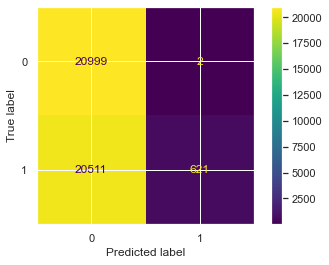

========== LightGBM Classifier ==========
Accuracy: 0.6940
F1 Score: 0.7084
AUC-ROC Score: 0.7550
-----------------------------------------
Precision: 0.6784
Recall: 0.7412


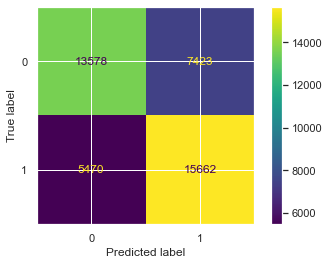

========= KNeighbors Classifier =========
Accuracy: 0.5306
F1 Score: 0.4947
AUC-ROC Score: 0.5434
-----------------------------------------
Precision: 0.5376
Recall: 0.4582


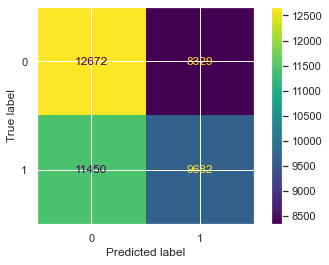

In [13]:
# starting training with player_id
_, lg = run_logistic_regression(df_data_player, c_matrix=True, r_curve=False);
_, lgbm = run_lightgbm_classifier(df_data_player, c_matrix=True, r_curve=False);
_, knc = run_kneighbors_classifier(df_data_player, c_matrix=True, r_curve=False);
save_metrics('6_with_player_ids', metrics_lg=lg, metrics_lgbm=lgbm, metrics_knc=knc )

<AxesSubplot:>

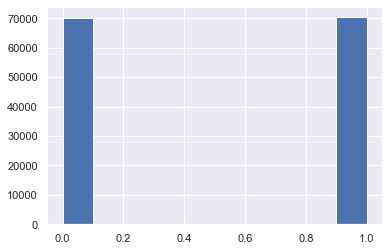

In [14]:
df_data_player.goal.hist()

## Adding player statistics

In [15]:
df_player_info = pd.read_csv('data/nhl/nhl_stats/player_info.csv')
df_player_info.head()

,player_id,firstName,lastName,nationality,birthCity,primaryPosition,birthDate,birthStateProvince,height,height_cm,weight,shootsCatches
0,8466148,Marian,Hossa,SVK,Stará Lubovna,RW,1979-01-12 00:00:00,NaN,"6' 1""",185.42,207.0,L
1,8465058,Michal,Rozsival,CZE,Vlasim,D,1978-09-03 01:00:00,NaN,"6' 1""",185.42,210.0,R
2,8476906,Shayne,Gostisbehere,USA,Pembroke Pines,D,1993-04-20 01:00:00,FL,"5' 11""",180.34,180.0,L
3,8466285,Brian,Campbell,CAN,Strathroy,D,1979-05-23 01:00:00,ON,"5' 10""",177.80,192.0,L
4,8470607,Brent,Seabrook,CAN,Richmond,D,1985-04-20 01:00:00,BC,"6' 3""",190.50,220.0,R


---
Calculating overall savePercentage for each goalie:

In [16]:
df_goalie = pd.read_csv('data/nhl/nhl_stats/game_goalie_stats.csv')
df_goalie = df_goalie.groupby('player_id').agg({'savePercentage':'mean'}).reset_index()
df_goalie.rename(columns={'player_id':'goalie_id'}, inplace=True)
df_goalie.head()                                      

,goalie_id,savePercentage
0,8445275,89.979639
1,8445386,89.914678
2,8445470,86.247964
3,8445769,90.347714
4,8446719,87.575872


---
Calculating overall statistics for each skater:

In [17]:
df_skater = pd.read_csv('data/nhl/nhl_stats/game_skater_stats.csv')
df_skater = df_skater.groupby('player_id').agg({'goals':'sum', 'shots':'sum', 'assists':'sum', 'timeOnIce':'sum'}).reset_index()
df_skater.rename(columns={'player_id':'skater_id'}, inplace=True)
df_skater.head()

,skater_id,goals,shots,assists,timeOnIce
0,8444894,11,66,12,51806
1,8444919,4,174,37,232930
2,8445000,88,696,74,322029
3,8445176,59,532,82,214915
4,8445266,7,185,23,329428


---
Merging it together in the training dataset

In [18]:
df_data_player = df_data_player.merge(df_skater, how='left', on='skater_id')
df_data_player = df_data_player.merge(df_goalie, how='left', on='goalie_id')

df_data_player

,play_id,st_x,st_y,period,periodTime,goal,secondaryType_Deflected,secondaryType_SlapShot,secondaryType_SnapShot,secondaryType_TipIn,...,secondaryType_WristShot,distance,angle,skater_id,goalie_id,goals,shots,assists,timeOnIce,savePercentage
0,2015020291_99,77.0,0.0,1,1019,1,0,0,0,0,...,1,23.000000,0.000000,8473573,8471403.0,216,1643,225,881126,89.991378
1,2011020834_325,33.0,29.0,3,849,1,0,1,0,0,...,0,73.006849,23.404690,8471240,8471306.0,11,229,65,478427,90.755161
2,2015020410_189,63.0,-5.0,2,857,1,0,0,0,0,...,1,37.336309,7.696052,8474685,8471734.0,126,1171,149,619081,90.486440
3,2018021182_195,82.0,-3.0,2,701,1,0,0,0,0,...,1,18.248288,9.462322,8478402,8475789.0,251,1600,463,671071,90.740269
4,2010020641_246,81.0,-10.0,3,207,1,0,0,0,0,...,1,21.470911,27.758541,8473548,8474550.0,439,4063,614,1423615,89.624936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140438,2010021204_47,35.0,25.0,1,594,0,0,1,0,0,...,0,69.641941,21.037511,8471303,8473404.0,119,2332,380,1475504,90.159493
140439,2015020567_282,78.0,-1.0,3,1116,0,0,0,0,0,...,1,22.022716,2.602562,8474567,8475852.0,57,1445,173,989850,90.305068
140440,2013030246_48,39.0,-32.0,1,376,0,0,0,0,0,...,1,68.883960,27.681062,8475764,8471734.0,87,1420,299,1186763,90.486440
140441,2018030154_52,49.0,-33.0,1,424,0,0,1,0,0,...,0,60.745370,32.905243,8474600,8471750.0,152,2541,434,1304459,91.123338


In [19]:
df_data_player.isna().sum()

play_id                        0
st_x                           0
st_y                           0
period                         0
periodTime                     0
goal                           0
secondaryType_Deflected        0
secondaryType_SlapShot         0
secondaryType_SnapShot         0
secondaryType_TipIn            0
secondaryType_Wraparound       0
secondaryType_WristShot        0
distance                       0
angle                          0
skater_id                      0
goalie_id                      0
goals                          0
shots                          0
assists                        0
timeOnIce                      0
savePercentage              2189
dtype: int64

In [20]:
# filling savePercentage
df_data_player.savePercentage.fillna(df_data_player.savePercentage.median(), inplace=True)
# drop the last row with NaNs
df_data_player.dropna(inplace=True)

In [37]:
df_ = pd.read_parquet('data/_8_with_player_salary.parquet')
_, lgbm = run_lightgbm_classifier(df_, c_matrix=False, r_curve=False);

========== LightGBM Classifier ==========
Accuracy: 0.6987
F1 Score: 0.7075
AUC-ROC Score: 0.7610
-----------------------------------------
Precision: 0.6790
Recall: 0.7384


In [36]:
# starting training with player stats
_, lg = run_logistic_regression(df_data_player, c_matrix=False, r_curve=False);
_, lgbm = run_lightgbm_classifier(df_data_player, c_matrix=False, r_curve=False);
_, knc = run_kneighbors_classifier(df_data_player, c_matrix=False, r_curve=False);
save_metrics('7_with_player_stats', metrics_lg=lg, metrics_lgbm=lgbm, metrics_knc=knc )

========== Logistic Regression ==========
Accuracy: 0.5517
F1 Score: 0.5008
AUC-ROC Score: 0.5822
-----------------------------------------
Precision: 0.5672
Recall: 0.4482
========== LightGBM Classifier ==========
Accuracy: 0.6971
F1 Score: 0.7114
AUC-ROC Score: 0.7601
-----------------------------------------
Precision: 0.6812
Recall: 0.7444
========= KNeighbors Classifier =========


KeyboardInterrupt: 

In [23]:
# saving the dataset for next improvements
df_data_player.to_parquet('data/benchmark.parquet', compression='BROTLI')

## Adding players salaries

In [24]:
# Data from another dataset
df_players_train = pd.read_csv('data/nhl/nhl_salaries/train.csv')
df_players_test = pd.read_csv('data/nhl/nhl_salaries/test.csv')

df_player_stats = pd.concat([df_players_train, df_players_test])
df_player_stats.head()

,Salary,Born,City,Pr/St,Cntry,Nat,Ht,Wt,DftYr,DftRd,...,PEND,OPS,DPS,PS,OTOI,Grit,DAP,Pace,GS,GS/G
0,925000.0,97-01-30,Sainte-Marie,QC,CAN,CAN,74,190,2015.0,1.0,...,1.0,0.0,-0.2,-0.2,40.03,1,0.0,175.7,-0.4,-0.38
1,2250000.0,93-12-21,Ottawa,ON,CAN,CAN,74,207,2012.0,1.0,...,98.0,-0.2,3.4,3.2,2850.59,290,13.3,112.5,14.1,0.18
2,8000000.0,88-04-16,St. Paul,MN,USA,USA,72,218,2006.0,1.0,...,70.0,3.7,1.3,5.0,2486.75,102,6.6,114.8,36.8,0.57
3,3500000.0,92-01-07,Ottawa,ON,CAN,CAN,77,220,2010.0,1.0,...,22.0,0.0,0.4,0.5,1074.41,130,17.5,105.1,5.9,0.20
4,1750000.0,94-03-29,Toronto,ON,CAN,CAN,76,217,2012.0,1.0,...,68.0,-0.1,1.4,1.3,3459.09,425,8.3,99.5,21.8,0.27


In [25]:
df_player_stats = df_player_stats[['First Name', 'Last Name', 'Nat', 'Salary']].rename(columns={'First Name':'firstName', 'Last Name':'lastName', 'Nat':'nationality', 'Salary':'salary'})
df_player_stats.head()

,firstName,lastName,nationality,salary
0,Thomas,Chabot,CAN,925000.0
1,Cody,Ceci,CAN,2250000.0
2,Kyle,Okposo,USA,8000000.0
3,Erik,Gudbranson,CAN,3500000.0
4,Tom,Wilson,CAN,1750000.0


---
Prepare player_info for merging

In [26]:
df_player_info.rename(columns={'player_id':'skater_id'}, inplace=True)
df_player_info.head()

,skater_id,firstName,lastName,nationality,birthCity,primaryPosition,birthDate,birthStateProvince,height,height_cm,weight,shootsCatches
0,8466148,Marian,Hossa,SVK,Stará Lubovna,RW,1979-01-12 00:00:00,NaN,"6' 1""",185.42,207.0,L
1,8465058,Michal,Rozsival,CZE,Vlasim,D,1978-09-03 01:00:00,NaN,"6' 1""",185.42,210.0,R
2,8476906,Shayne,Gostisbehere,USA,Pembroke Pines,D,1993-04-20 01:00:00,FL,"5' 11""",180.34,180.0,L
3,8466285,Brian,Campbell,CAN,Strathroy,D,1979-05-23 01:00:00,ON,"5' 10""",177.80,192.0,L
4,8470607,Brent,Seabrook,CAN,Richmond,D,1985-04-20 01:00:00,BC,"6' 3""",190.50,220.0,R


---
Add additional player's identification data to the target dataset: 

In [27]:
#add name and nationality of the skater
df_data_player = df_data_player.merge(df_player_info[['skater_id', 'firstName', 'lastName', 'nationality']], how='left', on='skater_id')
df_data_player

,play_id,st_x,st_y,period,periodTime,goal,secondaryType_Deflected,secondaryType_SlapShot,secondaryType_SnapShot,secondaryType_TipIn,...,skater_id,goalie_id,goals,shots,assists,timeOnIce,savePercentage,firstName,lastName,nationality
0,2015020291_99,77.0,0.0,1,1019,1,0,0,0,0,...,8473573,8471403.0,216,1643,225,881126,89.991378,Artem,Anisimov,RUS
1,2011020834_325,33.0,29.0,3,849,1,0,1,0,0,...,8471240,8471306.0,11,229,65,478427,90.755161,Jeff,Schultz,CAN
2,2015020410_189,63.0,-5.0,2,857,1,0,0,0,0,...,8474685,8471734.0,126,1171,149,619081,90.486440,Matt,Calvert,CAN
3,2018021182_195,82.0,-3.0,2,701,1,0,0,0,0,...,8478402,8475789.0,251,1600,463,671071,90.740269,Connor,McDavid,CAN
4,2010020641_246,81.0,-10.0,3,207,1,0,0,0,0,...,8473548,8474550.0,439,4063,614,1423615,89.624936,Phil,Kessel,USA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140438,2010021204_47,35.0,25.0,1,594,0,0,1,0,0,...,8471303,8473404.0,119,2332,380,1475504,90.159493,Alexander,Edler,SWE
140439,2015020567_282,78.0,-1.0,3,1116,0,0,0,0,0,...,8474567,8475852.0,57,1445,173,989850,90.305068,Zach,Bogosian,USA
140440,2013030246_48,39.0,-32.0,1,376,0,0,0,0,0,...,8475764,8471734.0,87,1420,299,1186763,90.486440,Cam,Fowler,USA
140441,2018030154_52,49.0,-33.0,1,424,0,0,1,0,0,...,8474600,8471750.0,152,2541,434,1304459,91.123338,Roman,Josi,CHE


---
Add salary to the merged dataset:

In [28]:
# add salary based on first name, last name, and the nationality
df_data_player = df_data_player.merge(df_player_stats, how='left', on=['firstName', 'lastName', 'nationality'])
df_data_player

,play_id,st_x,st_y,period,periodTime,goal,secondaryType_Deflected,secondaryType_SlapShot,secondaryType_SnapShot,secondaryType_TipIn,...,goalie_id,goals,shots,assists,timeOnIce,savePercentage,firstName,lastName,nationality,salary
0,2015020291_99,77.0,0.0,1,1019,1,0,0,0,0,...,8471403.0,216,1643,225,881126,89.991378,Artem,Anisimov,RUS,5750000.0
1,2011020834_325,33.0,29.0,3,849,1,0,1,0,0,...,8471306.0,11,229,65,478427,90.755161,Jeff,Schultz,CAN,NaN
2,2015020410_189,63.0,-5.0,2,857,1,0,0,0,0,...,8471734.0,126,1171,149,619081,90.486440,Matt,Calvert,CAN,2200000.0
3,2018021182_195,82.0,-3.0,2,701,1,0,0,0,0,...,8475789.0,251,1600,463,671071,90.740269,Connor,McDavid,CAN,NaN
4,2010020641_246,81.0,-10.0,3,207,1,0,0,0,0,...,8474550.0,439,4063,614,1423615,89.624936,Phil,Kessel,USA,9000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140438,2010021204_47,35.0,25.0,1,594,0,0,1,0,0,...,8473404.0,119,2332,380,1475504,90.159493,Alexander,Edler,SWE,NaN
140439,2015020567_282,78.0,-1.0,3,1116,0,0,0,0,0,...,8475852.0,57,1445,173,989850,90.305068,Zach,Bogosian,USA,5250000.0
140440,2013030246_48,39.0,-32.0,1,376,0,0,0,0,0,...,8471734.0,87,1420,299,1186763,90.486440,Cam,Fowler,USA,4000000.0
140441,2018030154_52,49.0,-33.0,1,424,0,0,1,0,0,...,8471750.0,152,2541,434,1304459,91.123338,Roman,Josi,CHE,4250000.0


___
Replace missing salary with median (to ignore outliers):

In [29]:
# replace missing salary
df_data_player.salary.fillna(df_data_player.salary.median(), inplace=True)

In [30]:
df_data_player.isna().sum()

play_id                     0
st_x                        0
st_y                        0
period                      0
periodTime                  0
goal                        0
secondaryType_Deflected     0
secondaryType_SlapShot      0
secondaryType_SnapShot      0
secondaryType_TipIn         0
secondaryType_Wraparound    0
secondaryType_WristShot     0
distance                    0
angle                       0
skater_id                   0
goalie_id                   0
goals                       0
shots                       0
assists                     0
timeOnIce                   0
savePercentage              0
firstName                   0
lastName                    0
nationality                 1
salary                      0
dtype: int64

In [31]:
df_data_player.savePercentage.fillna(df_data_player.savePercentage.median(), inplace=True)

#### Saving data to the dataset DataFrame

In [32]:
df_dataset = df_data_player.copy()

---
As we can see, there are new features for skater making the shot (goals, shots, assists, time on ice, salary) and for the goaling catching it (save percentage)

---

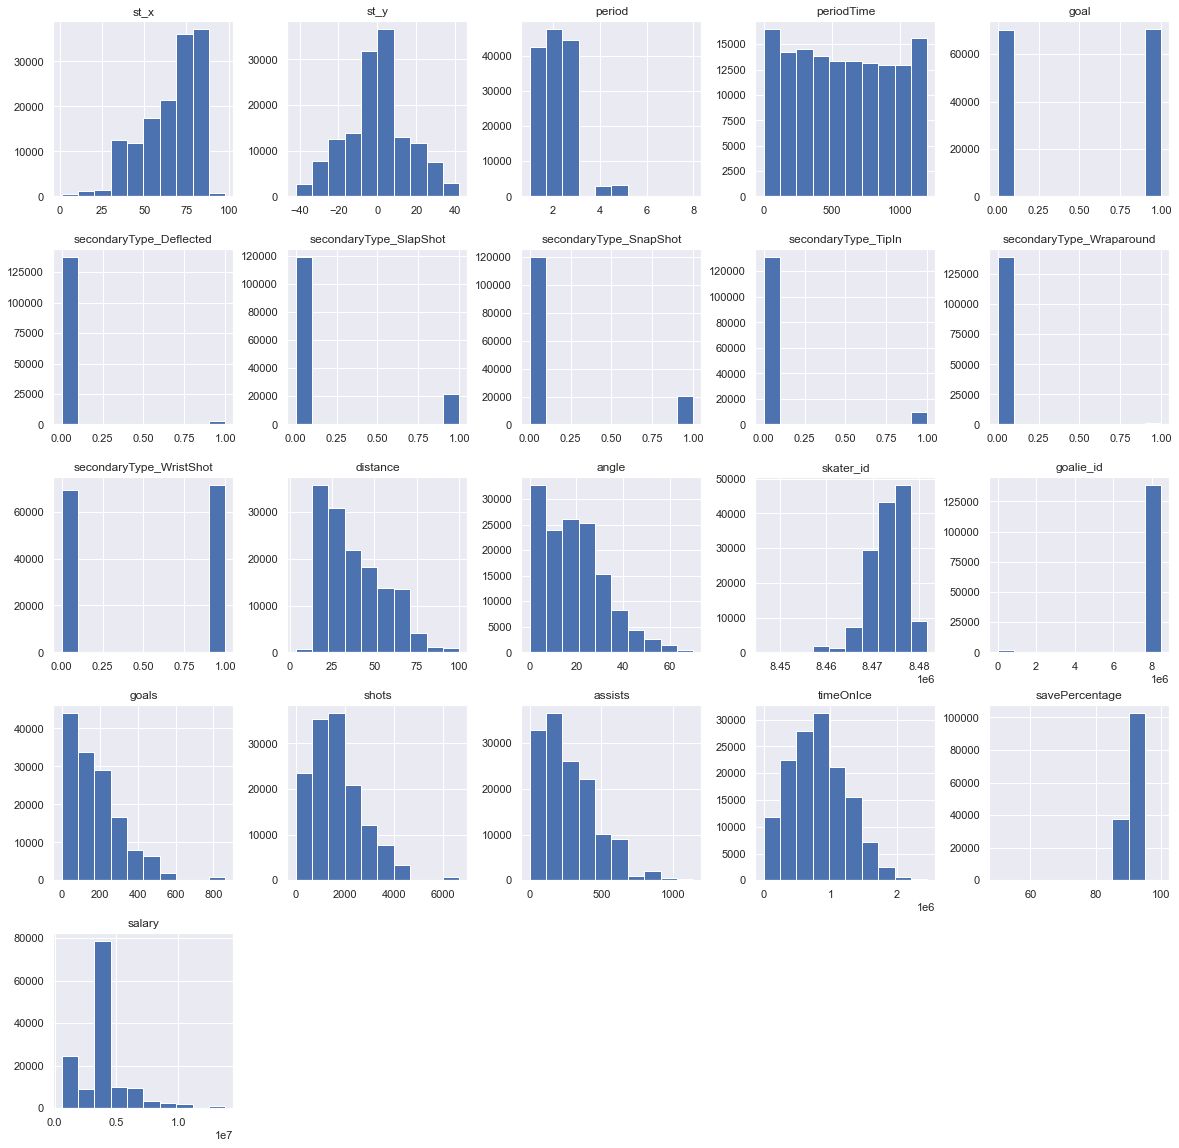

In [33]:
df_dataset.hist(figsize=(20, 20));

In [34]:
df_dataset = df_dataset[df_dataset.goals<400]
df_dataset = df_dataset[df_dataset.shots<4000]
df_dataset = df_dataset[df_dataset.assists<700]
df_dataset = df_dataset[df_dataset.salary<10000000]



## Re-train models with the new dataset including player's data

In [35]:
# starting training with player salary
_, lg = run_logistic_regression(df_dataset, c_matrix=False, r_curve=False);
_, lgbm = run_lightgbm_classifier(df_dataset, c_matrix=False, r_curve=False);
_, knc = run_kneighbors_classifier(df_dataset, c_matrix=False, r_curve=False);

save_metrics('8_with_player_salary', metrics_lg=lg, metrics_lgbm=lgbm, metrics_knc=knc)

========== Logistic Regression ==========
Accuracy: 0.5195
F1 Score: 0.0572
AUC-ROC Score: 0.5221
-----------------------------------------
Precision: 0.9928
Recall: 0.0295
========== LightGBM Classifier ==========
Accuracy: 0.6963
F1 Score: 0.7046
AUC-ROC Score: 0.7608
-----------------------------------------
Precision: 0.6795
Recall: 0.7315
========= KNeighbors Classifier =========
Accuracy: 0.5663
F1 Score: 0.5539
AUC-ROC Score: 0.5930
-----------------------------------------
Precision: 0.5642
Recall: 0.5440


There was not really and improvement in the model. The values are more or less same.

---


### Look at the feature importance

In [ ]:
features = df_dataset.select_dtypes(exclude='object').columns.to_list()
features.remove('goal')

target = 'goal'

lgbm_model, _ = run_lightgbm_classifier(df_dataset, features=features, target=target, c_matrix=False, r_curve=False);


col='goal'
corr = df_dataset.corr()
cmap = sns.diverging_palette(250, 20, as_cmap=True)

plt.subplots(1, 2, figsize=(40, 15))
plt.subplot(121)

plt.title('Feature correlation (goal)')
sns.heatmap(corr, cmap=cmap, vmin=-1, vmax=1, center=0, annot=True, linewidths=1, cbar_kws={"shrink": .5});

plt.subplot(122)
feature_imp = pd.DataFrame({'Importance':lgbm_model.feature_importances_,'Feature':features})
sns.barplot(x="Importance", y="Feature", palette='Blues_d', data=feature_imp.sort_values(by="Importance", ascending=False))
plt.title('LightGBM Feature Importance')
plt.show()

The most important features are goalie, dostance and agle. This definitely makes sense.

---

## Short vs. long distance shots

After all the feature engineering, let's see how is this model predisting on short vs. long distance shots. We split the dataset to two:

In [ ]:
df_short_dist = df_dataset[df_dataset.distance<30]
df_long_dist = df_dataset[df_dataset.distance>=30]

plt.subplots(1, 2, figsize=(10, 4))
plt.subplot(121)
df_short_dist.distance.hist();
plt.title('Short distance shots');
plt.subplot(122)
df_long_dist.distance.hist();
plt.title('Long distance shots');

---
Plotting locations of the short distance shots:

In [ ]:
plt.figure(figsize=(10, 6), dpi=80)
img=plt.imread('data/images/rink.jpg')
plt.grid()
plt.axis("off")
plt.imshow(img, extent=[-125, 125, -46, 46])
plt.scatter(df_short_dist.st_x, df_short_dist.st_y, s=20, c='moccasin', marker='x');
plt.title('Goals by shot type and location');

In [ ]:
plt.figure(figsize=(10, 6), dpi=80)
img=plt.imread('data/images/rink.jpg')
plt.grid()
plt.axis("off")
plt.imshow(img, extent=[-125, 125, -46, 46])
plt.scatter(df_long_dist.st_x, df_long_dist.st_y, s=20, c='peachpuff', marker='x');
plt.title('Goals by shot type and location');

---
Predicting goals for both this groups:

In [ ]:
# training with short distance shots
_, lg = run_logistic_regression(df_short_dist, c_matrix=False, r_curve=False);
_, lgbm = run_lightgbm_classifier(df_short_dist, c_matrix=False, r_curve=False);
_, knc = run_kneighbors_classifier(df_short_dist, c_matrix=False, r_curve=False);

save_metrics('9_short_dist', metrics_lg=lg, metrics_lgbm=lgbm, metrics_knc=knc)

In [ ]:
_, lg = run_logistic_regression(df_long_dist, c_matrix=False, r_curve=False);
_, lgbm = run_lightgbm_classifier(df_long_dist, c_matrix=False, r_curve=False);
_, knc = run_kneighbors_classifier(df_long_dist, c_matrix=False, r_curve=False);

save_metrics('10_long_dist', metrics_lg=lg, metrics_lgbm=lgbm, metrics_knc=knc)

---
### Conclusion on the short vs. long distance shots prediction: 
There is a huge difference between F1 score for predicting the goal probability for short distance vs. long distance shots. It looks like short distance goals are easier to predict. Those are apparently more dependent on featues recognized as important. On the other hand, the long distance goal do always include a **bit of luck**.


---
---